loaded 7069 files
skipped 3877 files for being outside region of interest
skipped 1596 files for being cloudy


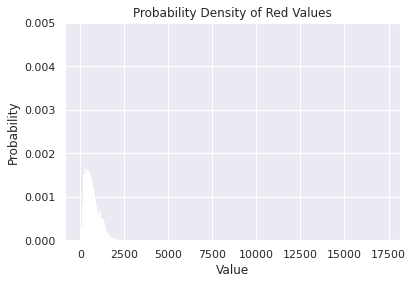

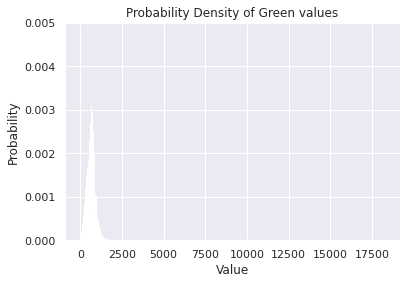

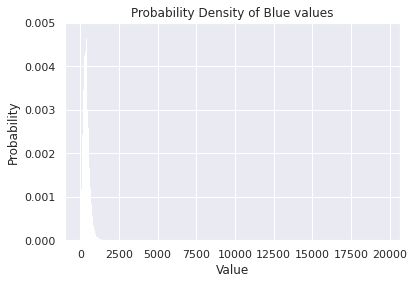

average value is 512.1266960870652
standard deviation is 324.87492004217927
75th percentile is 689.0
80th percentile is 744.0
85th percentile is 813.0
90th percentile is 913.0
95th percentile is 1100.0
98th percentile is 1348.0
maximum value seen is 19680.0
files with highest max values:
../../data/HiltonOfFern_crop_field_training_cloud_free_available_area/20190826/ROI1/S2/Patches/S1_17e20263-31a9-4625-863f-72a5c0d29dde_S2_f764bcb1-a983-4731-afeb-42fe613ac75e_2048_1536_256x256.tif had max value 19680.0
../../data/HiltonOfFern_crop_field_training_cloud_free_available_area/20190513/ROI1/S2/Patches/S1_e316e53f-5e52-486c-a5d5-e82e63d0c3bc_S2_780cee33-2b59-4171-8f6b-be8f221fbfca_1792_512_256x256.tif had max value 19200.0
../../data/HiltonOfFern_crop_field_training_cloud_free_available_area/20180827/ROI1/S2/Patches/S1_f78df197-5814-44ea-bfff-351e5e1ddb50_S2_722cd3b3-d490-4d4d-8de5-891e19d25d95_2048_1536_256x256.tif had max value 18576.0
../../data/HiltonOfFern_crop_field_training_cloud_free_

In [57]:
import numpy as np
import matplotlib.pyplot as plt
import os
import glob
import rasterio.io
import pprint
import seaborn as sns

HIGH_VALUE_CUT_OFF = 1348

DATASET_ROOT_PATH = '../../data/HiltonOfFern_crop_field_training_cloud_free_available_area/'
pp = pprint.PrettyPrinter(indent=4)

# use seaborn default style settings which are probably prettier than anything I'd design
sns.set() 


def replace_no_data_in_array(sentinel_data, array, replace_value=0):
  array[array == sentinel_data.profile['nodata']] = replace_value
  return array

def is_outside_roi(all_bands):
    total_non_zeros = np.count_nonzero(all_bands)
    threshold = float(all_bands.size) * 0.65
    # if less than 65% of values are not 0 presume outside our region of interest
    if float(total_non_zeros) < threshold:
        return True
    
    return False

total_files = 0
outside_roi = 0
cloudy = 0
max_seen = 0

file_max_values = {}
file_high_value_count = {}
file_average = {}
all_reds = np.array([])
all_greens = np.array([])
all_blues = np.array([])
all_vals = np.array([])

for cur_file in glob.glob(DATASET_ROOT_PATH + '/*/*/S2/Patches/*.tif'):

    #if cur_file.endswith("tif"):
    sentinel_data =  rasterio.open(cur_file)
    total_files = total_files + 1

    # load r,g & b values into 3 lists
    cur_red = replace_no_data_in_array(sentinel_data, sentinel_data.read(4))
    cur_green = replace_no_data_in_array(sentinel_data, sentinel_data.read(3))
    cur_blue = replace_no_data_in_array(sentinel_data, sentinel_data.read(2))
    cur_img = np.dstack((cur_red, cur_green, cur_blue))
    # convert list to numpy arrays
    cur_img = np.asarray(cur_img)

    # check if outside roi
    if is_outside_roi(cur_img):
        outside_roi = outside_roi + 1
        continue

    # load cloud data
    #medium_prob_cloud = replace_no_data_in_array(sentinel_data, sentinel_data.read(16))
    high_prod_cloud = replace_no_data_in_array(sentinel_data, sentinel_data.read(17))
    cirrus_cloud = replace_no_data_in_array(sentinel_data, sentinel_data.read(18))

    #cloud_mask = np.dstack((medium_prob_cloud, high_prod_cloud, cirrus_cloud))  
    cloud_mask = np.dstack((high_prod_cloud, cirrus_cloud))  

    # check for cloud data
    if np.any(cloud_mask):
        cloudy = cloudy + 1
        continue

    file_max_values[cur_file] = np.amax(cur_img)
    file_average[cur_file] = np.average(cur_img)
    file_high_value_count[cur_file] = np.count_nonzero(cur_img > HIGH_VALUE_CUT_OFF)

    all_reds = np.append(all_reds,cur_red)
    all_greens = np.append(all_greens,cur_green)
    all_blues = np.append(all_blues,cur_blue)
    #all_greens.extend(cur_green)
    #all_blues.extend(cur_blue)
    all_vals = np.concatenate((all_vals, cur_img.flatten()))

print("loaded " + str(total_files) + " files")
print("skipped " + str(outside_roi) + " files for being outside region of interest")
print("skipped " + str(cloudy) + " files for being cloudy")

# plot 3 histograms for rgb
all_reds = all_reds.flatten()


plt.figure(0)
plt.title("Probability Density of Red Values")
plt.hist(all_reds, bins='auto', density=True, facecolor='r')
plt.ylim(0,0.005)
plt.xlabel("Value")
plt.ylabel("Probability")
plt.show()

all_greens = all_greens.flatten()

plt.figure(1)
plt.title("Probability Density of Green values")
plt.hist(all_greens, bins='auto', density=True, facecolor='g')
plt.ylim(0,0.005)
plt.xlabel("Value")
plt.ylabel("Probability")
plt.show()

all_blues = all_blues.flatten()
plt.figure(2)
plt.title("Probability Density of Blue values")
plt.hist(all_blues, bins='auto', density=True, facecolor='b')
plt.ylim(0,0.005)
plt.xlabel("Value")
plt.ylabel("Probability")
plt.show()

# print average value
print("average value is " + str(np.average(all_vals)))
# print standard deviation
print("standard deviation is " + str(np.std(all_vals)))

percentiles_to_print = [75,80,85,90,95,98]
for cur_percent in percentiles_to_print:
    print(str(cur_percent) + "th percentile is " + str(np.percentile(all_vals, cur_percent)))
    
# print max value
print("maximum value seen is " + str(np.amax(all_vals)))

counter = 0
# list 10 files with highest max values
print("files with highest max values:")
for file in sorted(file_max_values, key=file_max_values.get, reverse=True):
    print(file + " had max value " + str(file_max_values[file]))
    counter = counter + 1
    if counter > 9:
        break
print("\n\n")
# list 10 files with most high values
counter = 0
print("files with most high values:")
for file in sorted(file_high_value_count, key=file_high_value_count.get, reverse=True):
    print(file + " had " + str(file_high_value_count[file]) + " values over " + str(HIGH_VALUE_CUT_OFF))
    counter = counter + 1
    if counter > 9:
        break
print("\n\n")
# list 10 files with highest average values
counter = 0
print("files with highest average values:")
for file in sorted(file_average, key=file_average.get, reverse=True):
    print(file + " had average value of " + str(file_average[file]))
    counter = counter + 1
    if counter > 9:
        break
print("\n\n")
# list 10 files with lowest average values
counter = 0
print("Files with lowest average values:")
for file in sorted(file_average, key=file_average.get, reverse=False):
    print(file + " had average value " + str(file_average[file]))
    counter = counter + 1
    if counter > 9:
        break
    